In [31]:
from __future__ import division

import numpy as np
from matplotlib import pyplot as plt
from matplotlib import patches as patches
import pandas as pd
%matplotlib inline
import pdb

In [32]:
raw_data=pd.read_csv("/home/hasan/files/simdatawdT.csv").values
raw_data=raw_data[:,1:]
print(raw_data.shape)

(21, 21)


In [33]:
network_dimensions = np.array([10, 10])
n_iterations = 10000
init_learning_rate = 0.01

normalise_data = True

# if True, assume all data on common scale
# if False, normalise to [0 1] range along each column
normalise_by_column = False

In [64]:
# establish variables based on data
m = raw_data.shape[0]
n = raw_data.shape[1]
print(m)
# initial neighbourhood radius
init_radius = max(network_dimensions[0], network_dimensions[1]) / 2
# radius decay parameter
time_constant = n_iterations / np.log(init_radius)

data = raw_data
#print(data)
# check if data needs to be normalised
if normalise_data:
    if normalise_by_column:
        # normalise along each column
        col_maxes = raw_data.max(axis=0)
        data = raw_data / col_maxes[np.newaxis, :]
    else:
        # normalise entire dataset
        data = raw_data / data.max()
print(data)

21
[[1.0 0.17142857142857143 0.17142857142857143 0.17142857142857143
  0.2571428571428572 0.14285714285714285 0.2571428571428572
  0.14285714285714285 0.14285714285714285 0.19999999999999998
  0.2571428571428572 0.19999999999999998 0.17142857142857143
  0.34285714285714286 0.14285714285714285 0.42857142857142855
  0.14285714285714285 0.2857142857142857 0.31428571428571433
  0.14285714285714285 0.19999999999999998]
 [0.2285714285714286 1.0 0.2285714285714286 0.42857142857142855
  0.14285714285714285 0.8285714285714285 0.19999999999999998
  0.39999999999999997 0.19999999999999998 0.19999999999999998
  0.37142857142857144 0.2285714285714286 0.14285714285714285
  0.2285714285714286 0.42857142857142855 0.17142857142857143
  0.6571428571428571 0.2571428571428572 0.17142857142857143
  0.19999999999999998 0.14285714285714285]
 [0.31428571428571433 0.14285714285714285 1.0 0.17142857142857143
  0.39999999999999997 0.14285714285714285 0.39999999999999997
  0.17142857142857143 0.14285714285714285 

In [35]:
# setup random weights between 0 and 1
# weight matrix needs to be one m-dimensional vector for each neuron in the SOM
net = np.random.random((network_dimensions[0], network_dimensions[1], m))
print(net)

[[[0.94740172 0.81978749 0.66612662 ... 0.24751565 0.47871662 0.88681824]
  [0.30634451 0.80488439 0.95827778 ... 0.9796257  0.53824416 0.97624139]
  [0.74885045 0.47203416 0.99207747 ... 0.87340158 0.58623716 0.06587843]
  ...
  [0.33226436 0.88918553 0.95350665 ... 0.71388145 0.36370406 0.51415439]
  [0.28170385 0.28408134 0.68262441 ... 0.65870408 0.79460734 0.24192276]
  [0.89935803 0.74593964 0.93132826 ... 0.8555367  0.27766452 0.15437604]]

 [[0.28391295 0.22415517 0.3193531  ... 0.69353512 0.32625688 0.50209101]
  [0.8599245  0.10847696 0.92381105 ... 0.76539724 0.9487037  0.0469495 ]
  [0.79687363 0.13085272 0.47389568 ... 0.5934723  0.94149515 0.84833614]
  ...
  [0.98135483 0.96339518 0.38450122 ... 0.36455702 0.80054603 0.38751213]
  [0.81399837 0.65808514 0.16252407 ... 0.79465115 0.14973329 0.06203798]
  [0.79977026 0.08882456 0.33579985 ... 0.10477375 0.58412927 0.92400992]]

 [[0.17370335 0.48579058 0.51007073 ... 0.03120327 0.47194201 0.50754624]
  [0.78321049 0.844452

In [36]:

def find_bmu(t, net, m):
    """
        Find the best matching unit for a given vector, t, in the SOM
        Returns: a (bmu, bmu_idx) tuple where bmu is the high-dimensional BMU
                 and bmu_idx is the index of this vector in the SOM
    """
    bmu_idx = np.array([0, 0])
    # set the initial minimum distance to a huge number
    min_dist = np.iinfo(np.int).max    
    # calculate the high-dimensional distance between each neuron and the input
    for x in range(net.shape[0]):
        for y in range(net.shape[1]):
            w = net[x, y, :].reshape(m, 1)
            # don't bother with actual Euclidean distance, to avoid expensive sqrt operation
            sq_dist = np.sum((w - t) ** 2)
            if sq_dist < min_dist:
                min_dist = sq_dist
                bmu_idx = np.array([x, y])
    # get vector corresponding to bmu_idx
    bmu = net[bmu_idx[0], bmu_idx[1], :].reshape(m, 1)
    # return the (bmu, bmu_idx) tuple
    return (bmu, bmu_idx)

In [37]:

def decay_radius(initial_radius, i, time_constant):
    return initial_radius * np.exp(-i / time_constant)

In [38]:
def decay_learning_rate(initial_learning_rate, i, n_iterations):
    return initial_learning_rate * np.exp(-i / n_iterations)

In [39]:
def calculate_influence(distance, radius):
    return np.exp(-distance / (2* (radius**2)))

In [40]:
for i in range(n_iterations):
    #print('Iteration %d' % i)
    
    # select a training example at random
    t = data[:, np.random.randint(0, n)].reshape(np.array([m, 1]))
    #print("first t value:", t);
    
    # find its Best Matching Unit
    bmu, bmu_idx = find_bmu(t, net, m)
    #print("bmu_index: ",bmu_idx)
    
    # decay the SOM parameters
    r = decay_radius(init_radius, i, time_constant)
    l = decay_learning_rate(init_learning_rate, i, n_iterations)
    
    # now we know the BMU, update its weight vector to move closer to input
    # and move its neighbours in 2-D space closer
    # by a factor proportional to their 2-D distance from the BMU
    for x in range(net.shape[0]):
        for y in range(net.shape[1]):
            w = net[x, y, :].reshape(m, 1)
            
            #print("net",net)
            #print("wwww:",w)
            # get the 2-D distance (again, not the actual Euclidean distance)
            w_dist = np.sum((np.array([x, y]) - bmu_idx) ** 2)
            # if the distance is within the current neighbourhood radius
            if w_dist <= r**2:
                # calculate the degree of influence (based on the 2-D distance)
                influence = calculate_influence(w_dist, r)
                # now update the neuron's weight using the formula:
                # new w = old w + (learning rate * influence * delta)
                # where delta = input vector (t) - old w
                new_w = w + (l * influence * (t - w))
                # commit the new weight
                net[x, y, :] = new_w.reshape(1, 21)
                

In [41]:
material_nams=\
["Adhesive","Brick","Cardboard","Ceramic","Cloth","Concrete","Cotton","Diamond","Glass","Leather","Marble","Metal","Paper","Plastic","Porcelain","Rubber","Stone","Styrofoam","Wax","Wood","Wool"]

In [54]:
#for i, m in enumerate(net):
    #print(m[1])   t=m[1].reshape(1,21)
    
print("m10:",net.shape)
    #plt.text(m[1], material_nams[i], ha='center', va='center',
    #     bbox=dict(facecolor='white', alpha=1, lw=0))




m10: (10, 10, 21)


In [43]:
def find_classification(t, net, m):
  
    bmu_idx = np.array([0, 0])
    # set the initial minimum distance to a huge number
    min_dist = np.iinfo(np.int).max    
    # calculate the high-dimensional distance between each neuron and the input
    for x in range(net.shape[0]):
        for y in range(net.shape[1]):
            w = net[x, y, :].reshape(m, 1)
            # don't bother with actual Euclidean distance, to avoid expensive sqrt operation
            sq_dist = np.sum((w - t) ** 2)
            if sq_dist < min_dist:
                min_dist = sq_dist
                bmu_idx = np.array([x, y])
    # get vector corresponding to bmu_idx
    bmu = net[bmu_idx[0], bmu_idx[1], :].reshape(m, 1)
    # return the (bmu, bmu_idx) tuple
    return (bmu, bmu_idx)

In [88]:
list3=[1,2,2,1,1,2,1,2,2,1,1,2,2,3,1,1,2,1,2,2,1]
list4=[2,3,2,2,1,3,1,3,3,1,2,3,2,4,2,1,3,1,2,4,1]

In [44]:
bmu_index:  [1 2]
bmu_index:  [2 3]
bmu_index:  [2 2]
bmu_index:  [1 2]
bmu_index:  [1 1]
bmu_index:  [2 3]
bmu_index:  [1 1]
bmu_index:  [2 3]
bmu_index:  [2 3]
bmu_index:  [1 1]
bmu_index:  [1 2]
bmu_index:  [2 3]
bmu_index:  [2 2]
bmu_index:  [3 4]
bmu_index:  [1 2]
bmu_index:  [1 1]
bmu_index:  [2 3]
bmu_index:  [1 1]
bmu_index:  [2 2]
bmu_index:  [2 4]
bmu_index:  [1 1]

SyntaxError: invalid syntax (<ipython-input-44-a0061baa1032>, line 1)

In [71]:
group = np.zeros(21)
list1 = []
list2 =[]
for i in range(21):
    
    #print('Iteration %d' % i)
    # select a training example at random
    t = data[:, i].reshape(np.array([m, 1]))
    #t = data[:, i].reshape(np.array([m, 1]))
    #print("first t value:", t);
    #print(t)
    # find its Best Matching Unit
    bmu, bmu_idx = find_classification(t, net, m)
    print("bmu_index: ",bmu_idx)
    group[i]=bmu_idx[0]
    list1.append(bmu_idx[0])
    list2.append(bmu_idx[1])
   

bmu_index:  [9 6]
bmu_index:  [5 8]
bmu_index:  [4 2]
bmu_index:  [0 3]
bmu_index:  [8 0]
bmu_index:  [4 9]
bmu_index:  [9 0]
bmu_index:  [3 6]
bmu_index:  [2 4]
bmu_index:  [8 2]
bmu_index:  [0 8]
bmu_index:  [8 9]
bmu_index:  [6 0]
bmu_index:  [0 0]
bmu_index:  [0 5]
bmu_index:  [9 4]
bmu_index:  [2 9]
bmu_index:  [2 1]
bmu_index:  [7 6]
bmu_index:  [5 4]
bmu_index:  [9 0]


In [72]:
print(list1,list2)

[9, 5, 4, 0, 8, 4, 9, 3, 2, 8, 0, 8, 6, 0, 0, 9, 2, 2, 7, 5, 9] [6, 8, 2, 3, 0, 9, 0, 6, 4, 2, 8, 9, 0, 0, 5, 4, 9, 1, 6, 4, 0]


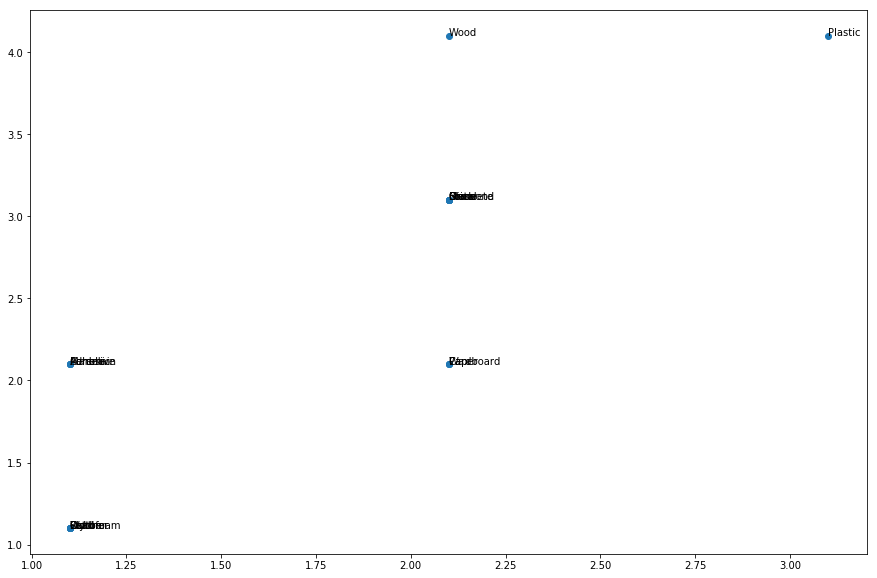

In [93]:
print("Graph for 5*5 size SOM")
    #print(m[1])
    
    #print("m10:",list1[1])
    #plt.text(list1,list2, material_nams[i], ha='center', va='center',
     #    bbox=dict(facecolor='white', alpha=1, lw=0))

f = plt.figure(figsize=(15,10))
ax = f.subplots()
ax.scatter(list3, list4)
    
for i, txt in enumerate(material_nams):
    
    ax.annotate(txt, (list3[i], list4[i]))
    list3[i]+=0.3
    list4[i]+=0.3

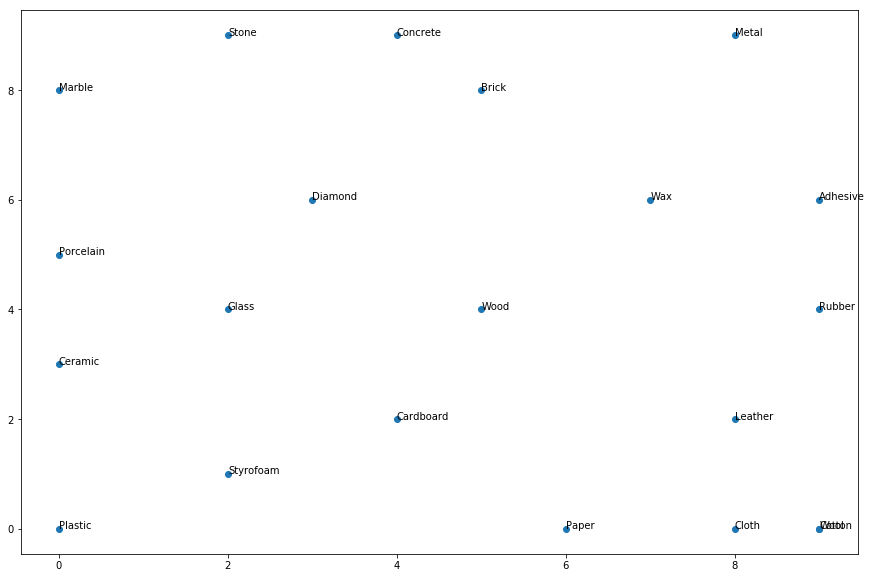

In [90]:
print("Graph for 10*10 size SOM")
f = plt.figure(figsize=(15,10))
ax = f.subplots()
ax.scatter(list1, list2)
    
for i, txt in enumerate(material_nams):
    
    ax.annotate(txt, (list1[i], list2[i]))

8
9
8
2
8
4
8
0
8
9
8
8
8
9
8
9
8
8
8
4
8
2
8
8
8
9
8
9
8
4
8
8
8
8
8
5
8
9
8
8
8
9
4
9
4
2
4
4
4
0
4
9
4
8
4
9
4
9
4
8
4
4
4
2
4
8
4
9
4
9
4
4
4
8
4
8
4
5
4
9
4
8
4
9
8
9
8
2
8
4
8
0
8
9
8
8
8
9
8
9
8
8
8
4
8
2
8
8
8
9
8
9
8
4
8
8
8
8
8
5
8
9
8
8
8
9
9
9
9
2
9
4
9
0
9
9
9
8
9
9
9
9
9
8
9
4
9
2
9
8
9
9
9
9
9
4
9
8
9
8
9
5
9
9
9
8
9
9
2
9
2
2
2
4
2
0
2
9
2
8
2
9
2
9
2
8
2
4
2
2
2
8
2
9
2
9
2
4
2
8
2
8
2
5
2
9
2
8
2
9
8
9
8
2
8
4
8
0
8
9
8
8
8
9
8
9
8
8
8
4
8
2
8
8
8
9
8
9
8
4
8
8
8
8
8
5
8
9
8
8
8
9
8
9
8
2
8
4
8
0
8
9
8
8
8
9
8
9
8
8
8
4
8
2
8
8
8
9
8
9
8
4
8
8
8
8
8
5
8
9
8
8
8
9
0
9
0
2
0
4
0
0
0
9
0
8
0
9
0
9
0
8
0
4
0
2
0
8
0
9
0
9
0
4
0
8
0
8
0
5
0
9
0
8
0
9
4
9
4
2
4
4
4
0
4
9
4
8
4
9
4
9
4
8
4
4
4
2
4
8
4
9
4
9
4
4
4
8
4
8
4
5
4
9
4
8
4
9
2
9
2
2
2
4
2
0
2
9
2
8
2
9
2
9
2
8
2
4
2
2
2
8
2
9
2
9
2
4
2
8
2
8
2
5
2
9
2
8
2
9
9
9
9
2
9
4
9
0
9
9
9
8
9
9
9
9
9
8
9
4
9
2
9
8
9
9
9
9
9
4
9
8
9
8
9
5
9
9
9
8
9
9
2
9
2
2
2
4
2
0
2
9
2
8
2
9
2
9
2
8
2
4
2
2
2
8
2
9
2
9
2
4
2
8
2
8
2
5
2
9
